In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, mean_squared_error, 
mean_absolute_error, r2_score, f1_score, precision_recall_fscore_support, roc_auc_score)
from sklearn.model_selection import GridSearchCV
import joblib
from joblib import dump

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    
    """
    This function calculates mean_absolute_percentage_error
    
    Input:
        y_true (array): True values
        y_pred (array): Preicted values

    Returns: 
        Calculated MAPE 
    
    """
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [9]:
data=pd.read_csv('data/data_full_features.csv')
data=data.drop('Unnamed: 0',axis=1)
data

,crime_type,point_x,point_y,Year,Month,Day,Hour,Minute,Weekday,IsWeekend,street_name,block_number,distance_to_nearest_police_station,temperature_2m_max (°F),temperature_2m_min (°F),temperature_2m_mean (°F),precipitation_sum (mm),precipitation_hours (h),Unemployment Rate of a Population
0,Robbery Firearm,-75.072610,40.041574,2023,10,13,23,54,4,0,BLOCK LARGE,6600,0.017699,65.5,51.5,57.2,0.0,0.0,5.4
1,Other Assaults,-75.172952,39.999995,2023,10,13,23,27,4,0,BLOCK N,2900,0.019584,65.5,51.5,57.2,0.0,0.0,5.4
2,Thefts,-75.108462,39.994303,2023,10,13,23,27,4,0,BLOCK JOYCE,3200,0.028199,65.5,51.5,57.2,0.0,0.0,5.4
3,Thefts,-75.136074,39.991890,2023,10,13,23,24,4,0,BLOCK N,2700,0.029554,65.5,51.5,57.2,0.0,0.0,5.4
4,Robbery Firearm,-75.107092,40.032184,2023,10,13,23,19,4,0,BLOCK ADAMS,700,0.038528,65.5,51.5,57.2,0.0,0.0,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845090,Weapon Violations,-75.162731,39.996640,2006,1,1,0,10,6,1,BLOCK W,1900,0.016373,45.5,30.5,36.5,0.0,0.0,6.7
2845091,Weapon Violations,-75.147908,40.054432,2006,1,1,0,9,6,1,BLOCK N,6600,0.014318,45.5,30.5,36.5,0.0,0.0,6.7
2845092,Weapon Violations,-75.230637,39.937516,2006,1,1,0,5,6,1,BLOCK S,1700,0.015256,45.5,30.5,36.5,0.0,0.0,6.7
2845093,Weapon Violations,-75.232361,39.953284,2006,1,1,0,4,6,1,BLOCK S,400,0.001530,45.5,30.5,36.5,0.0,0.0,6.7


# EDA

### Count of each crime type 

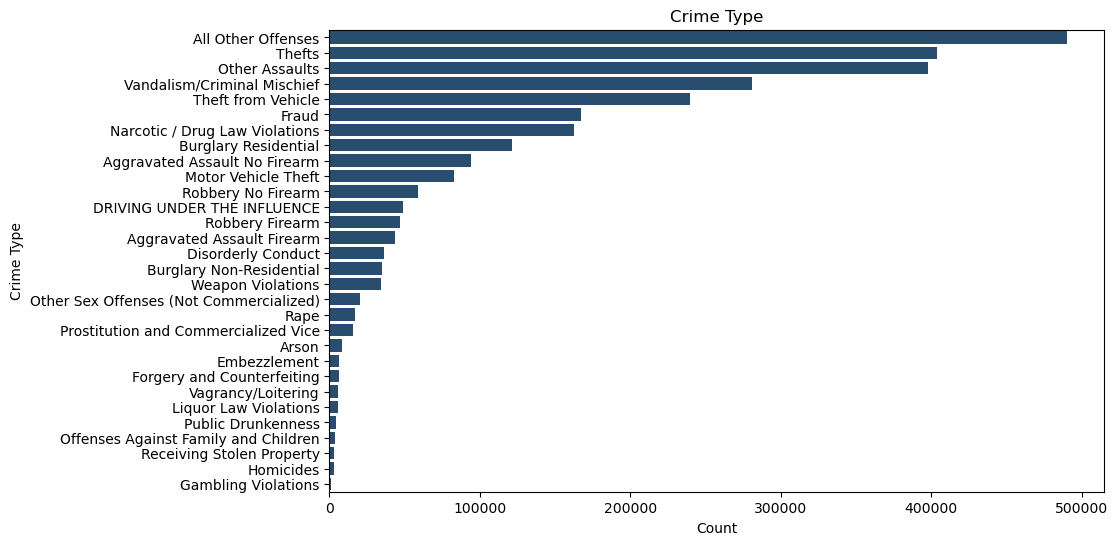

In [10]:
crime_counts = data['crime_type'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.countplot(data=data, y='crime_type', color='#1E4D79', order=crime_counts.index)
plt.title('Crime Type')  # Add title
plt.xlabel('Count')  # Add x-axis label if needed
plt.ylabel('Crime Type')  # Add y-axis label if needed
plt.show()

### Count of crime per year

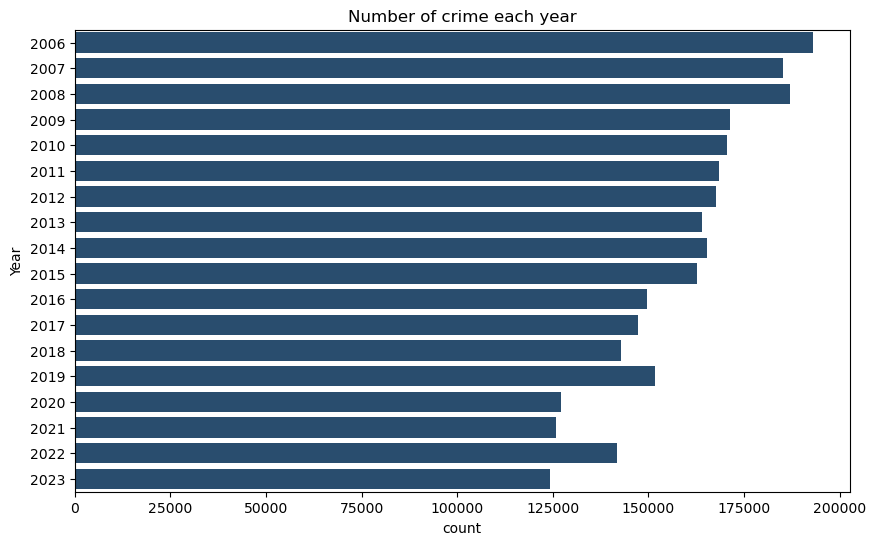

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data,y='Year',color='#1E4D79')
plt.title('Number of crime each year')  # Add title
plt.show()

In [36]:
def growth_rate(df):
    growth=[]
    for i in range(0,len(df)):
        if i==0:
            growth.append(0)
            continue
        growth.append(((df['Count'].iloc[i]-df['Count'].iloc[i-1])/df['Count'].iloc[i-1])*100)
    return growth

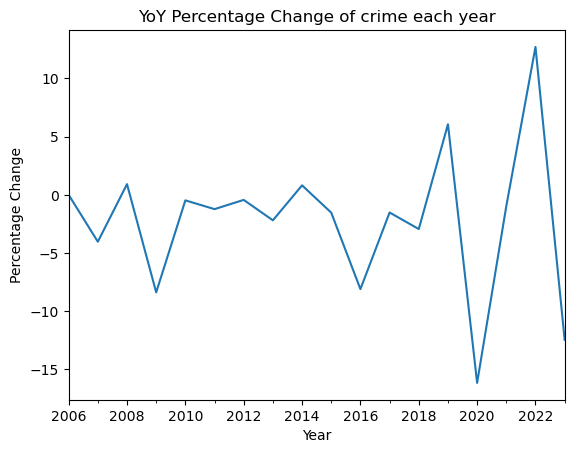

In [45]:
yearly_crime_count = data['Year'].value_counts().sort_index()
yearly_crime_count
yearly_crime_count_df = yearly_crime_count.reset_index()
yearly_crime_count_df.columns = ['Year', 'Count']
#yearly_crime_count_df
yearly_crime_count_df['Percentage Change']=growth_rate(yearly_crime_count_df)

# Convert the 'Year' column into a datetime index
yearly_crime_count_df['Year'] = pd.to_datetime(yearly_crime_count_df['Year'], format='%Y')

# Set the 'Year' column as the index of the DataFrame
yearly_crime_count_df.set_index('Year', inplace=True)

yearly_crime_count_df  # Display the DataFrame with a datetime index

yearly_crime_count_df['Percentage Change'].plot()
plt.title('YoY Percentage Change of crime each year')  # Add title
plt.ylabel('Percentage Change')
plt.show()

### Crime count on weekends vs weekdays

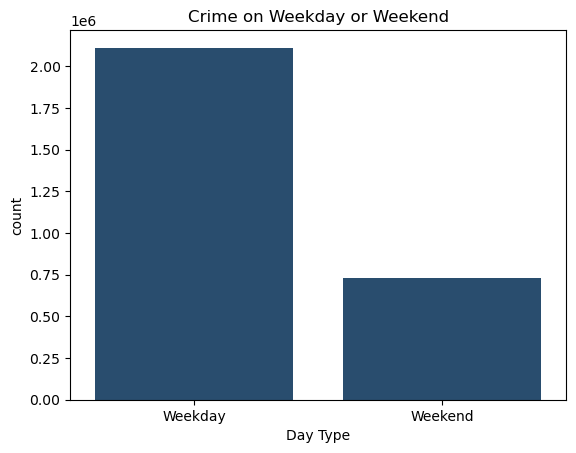

In [10]:
data['Day Type'] = data['IsWeekend'].map({0: 'Weekday', 1: 'Weekend'})

sns.countplot(data=data,x='Day Type',color='#1E4D79')
plt.title('Crime on Weekday or Weekend')  # Add title
plt.show()

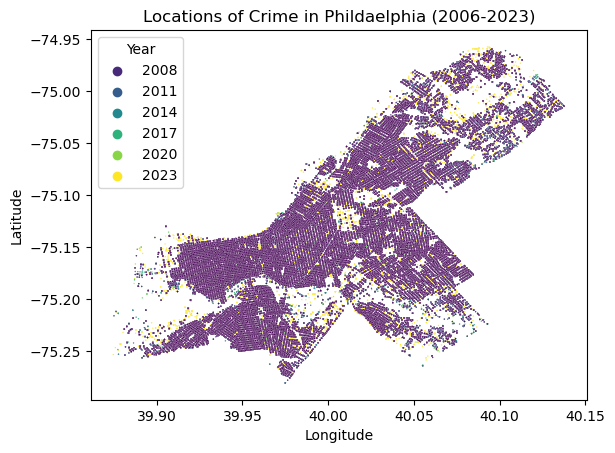

In [11]:
import matplotlib.pyplot as plt
sns.scatterplot(x=data['point_y'], y=data['point_x'], color='#1E4D79', s=1,hue=data['Year'],palette='viridis')  # Adjust 's' for marker size

plt.title('Locations of Crime in Phildaelphia (2006-2023)')  # Add title
plt.xlabel('Longitude')  # Change x-axis label
plt.ylabel('Latitude')  # Change y-axis label
plt.show()

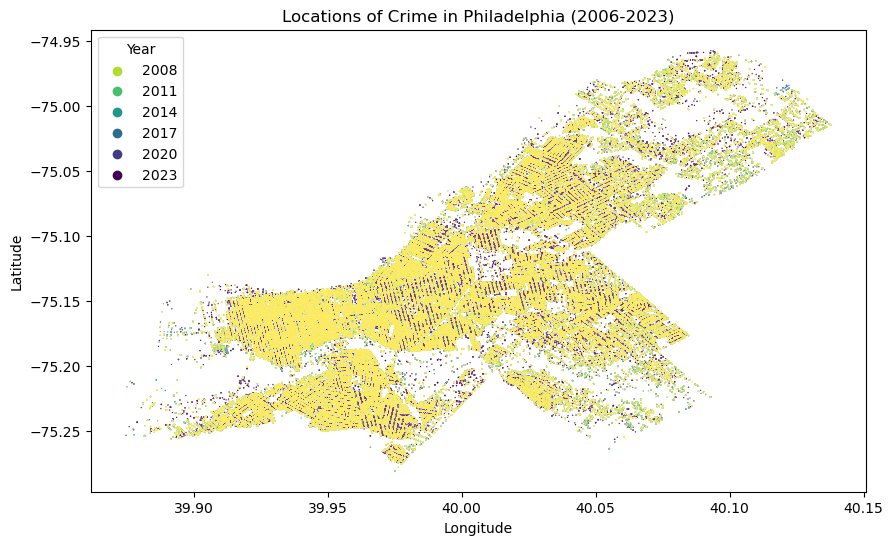

In [12]:
custom_palette = sns.color_palette('viridis', as_cmap=True)
custom_palette = custom_palette.reversed()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['point_y'], y=data['point_x'], hue=data['Year'], palette=custom_palette, s=1)

plt.title('Locations of Crime in Philadelphia (2006-2023)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Year')

plt.show()

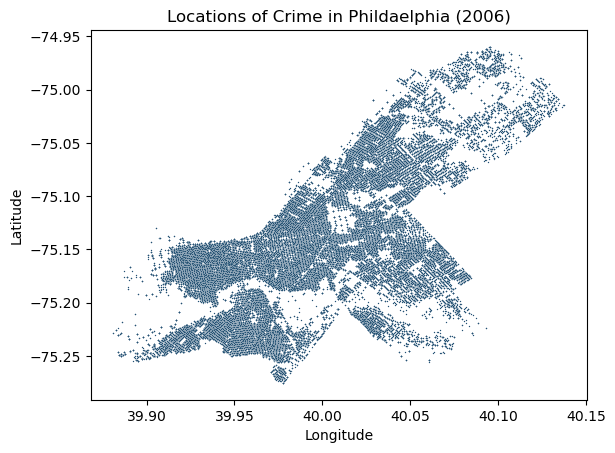

In [13]:
sns.scatterplot(x=data[data['Year']==2006]['point_y'], y=data[data['Year']==2006]['point_x'], color='#1E4D70', s=1)  # Adjust 's' for marker size
plt.title('Locations of Crime in Phildaelphia (2006)')  # Add title
plt.xlabel('Longitude')  # Change x-axis label
plt.ylabel('Latitude')  # Change y-axis label
plt.show()

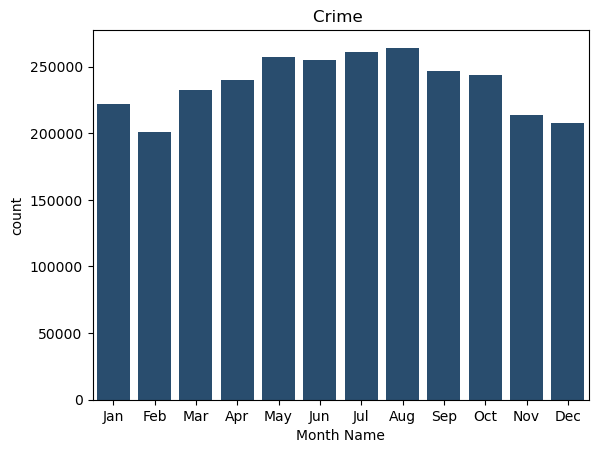

In [15]:
data['Month Name'] = data['Month'].map({1: 'Jan',
                                        2: 'Feb',
                                       3: 'Mar',
                                       4: 'Apr',
                                       5: 'May',
                                       6: 'Jun',
                                       7: 'Jul',
                                       8: 'Aug',
                                       9: 'Sep',
                                       10: 'Oct',
                                       11: 'Nov',
                                       12: 'Dec',})

sns.countplot(data=data,x='Month Name',color='#1E4D79',
              order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title('Crime ')  # Add title
plt.show()

In [18]:
def categorize_time(hour):
    if 5 <= hour <= 7:
        return "Early Morning"
    elif 8 <= hour <= 11:
        return "Morning"
    elif 12 <= hour <= 15:
        return "Afternoon"
    elif 16 <= hour <= 19:
        return "Evening"
    elif 20 <= hour <= 23:
        return "Late Evening"
    else:
        return "Night"

# Apply the function to create a new column
data['time_of_day'] = data['Hour'].apply(categorize_time)

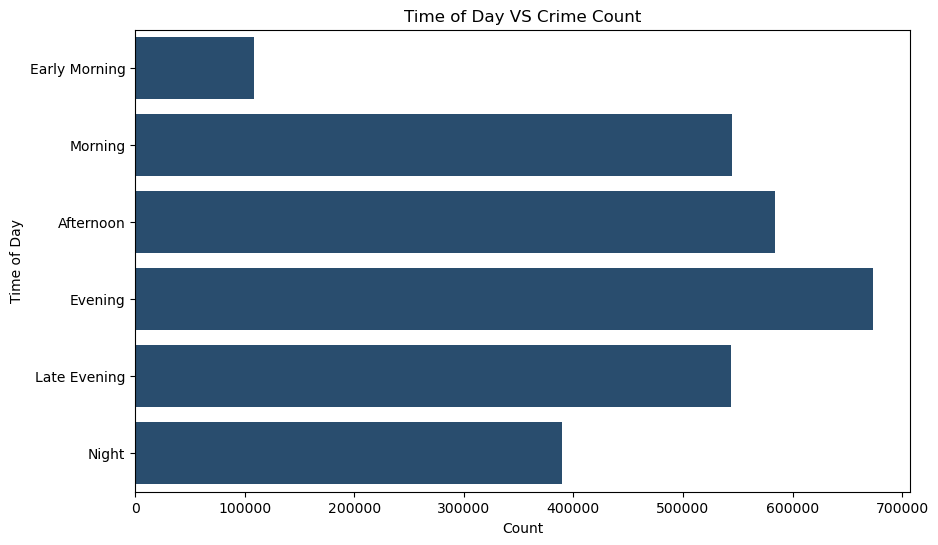

In [19]:
crime_counts = data['time_of_day'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.countplot(data=data, y='time_of_day', color='#1E4D79',order=['Early Morning','Morning','Afternoon','Evening'
                                                                 ,'Late Evening','Night'])
plt.title('Time of Day VS Crime Count')  # Add title
plt.xlabel('Count')  # Add x-axis label if needed
plt.ylabel('Time of Day')  # Add y-axis label if needed
plt.show()

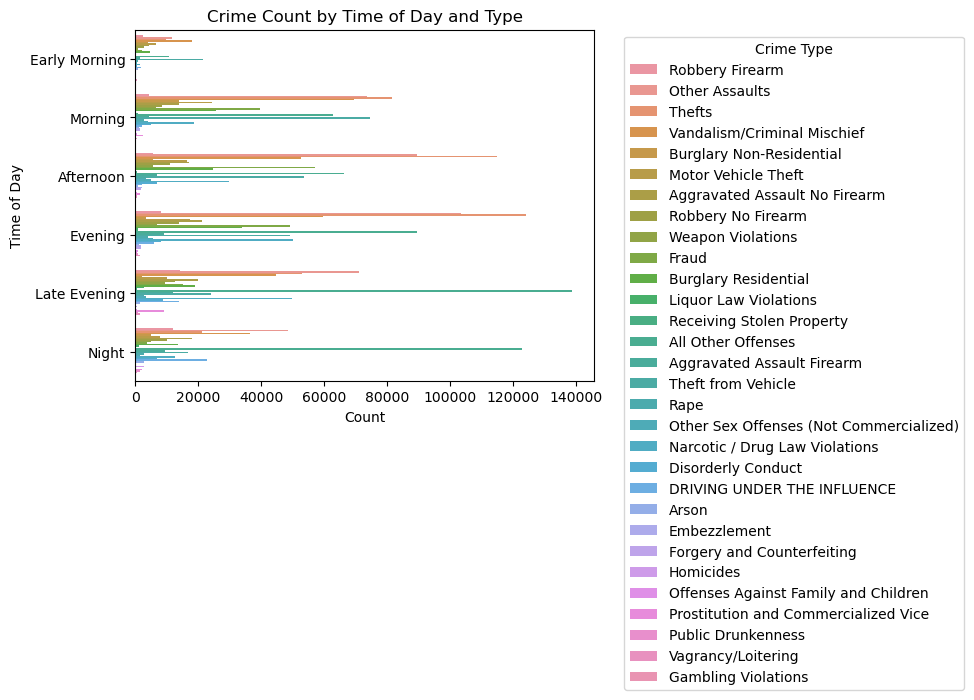

In [20]:


# Plotting the stacked bar chart
plt.figure(figsize=(10, 6))
sns.countplot(data=data, y='time_of_day', hue='crime_type', order=['Early Morning','Morning','Afternoon','Evening','Late Evening','Night'])
plt.title('Crime Count by Time of Day and Type')
plt.xlabel('Count')
plt.ylabel('Time of Day')
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [21]:
crime_severity_mapping = {
    'Robbery Firearm': 'Severe',
    'Other Assaults': 'Moderate',
    'Thefts': 'Minor',
    'Vandalism/Criminal Mischief': 'Moderate',
    'Burglary Non-Residential': 'Moderate',
    'Motor Vehicle Theft': 'Moderate',
    'Aggravated Assault No Firearm': 'Severe',
    'Robbery No Firearm': 'Moderate',
    'Weapon Violations': 'Moderate',
    'Fraud': 'Minor',
    'Burglary Residential': 'Moderate',
    'Liquor Law Violations': 'Minor',
    'Receiving Stolen Property': 'Minor',
    'All Other Offenses': 'Minor',
    'Aggravated Assault Firearm': 'Severe',
    'Theft from Vehicle': 'Minor',
    'Rape': 'Severe',
    'Other Sex Offenses (Not Commercialized)': 'Moderate',
    'Narcotic / Drug Law Violations': 'Moderate',
    'Disorderly Conduct': 'Minor',
    'DRIVING UNDER THE INFLUENCE': 'Moderate',
    'Arson': 'Severe',
    'Embezzlement': 'Minor',
    'Forgery and Counterfeiting': 'Minor',
    'Homicides': 'Severe',
    'Offenses Against Family and Children': 'Moderate',
    'Prostitution and Commercialized Vice': 'Moderate',
    'Public Drunkenness': 'Minor',
    'Vagrancy/Loitering': 'Minor',
    'Gambling Violations': 'Minor'
}

data['degree_of_crime'] = data['crime_type'].map(crime_severity_mapping)

# Handle any crimes that were not classified (if any)
#data['degree_of_crime'].fillna('Unknown', inplace=True)
data['degree_of_crime'].value_counts()

Minor       1370498
Moderate    1261897
Severe       212700
Name: degree_of_crime, dtype: int64

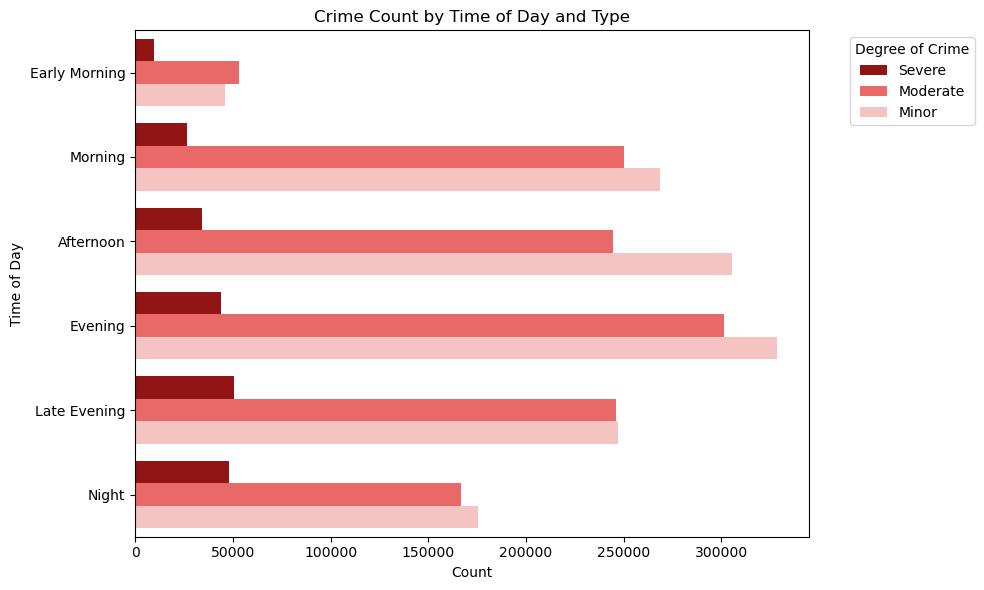

In [22]:
crime_degree_colors = {
    'Minor': '#ffbaba',
    'Moderate': '#ff5252',
    'Severe': '#a70000'
}

# Plotting the stacked bar chart
plt.figure(figsize=(10, 6))
sns.countplot(data=data, y='time_of_day', hue='degree_of_crime',
              order=['Early Morning','Morning','Afternoon','Evening','Late Evening','Night'],
             palette=crime_degree_colors)
plt.title('Crime Count by Time of Day and Type')
plt.xlabel('Count')
plt.ylabel('Time of Day')
plt.legend(title='Degree of Crime', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Time Series - Daily Crime

In [47]:
import pandas as pd
timeseries=data.copy()
# Assuming your data is loaded into a DataFrame named `df`
# First, ensure that your date and time columns are integers
timeseries['Year'] = timeseries['Year'].astype(int)
timeseries['Month'] = timeseries['Month'].astype(int)
timeseries['Day'] = timeseries['Day'].astype(int)
timeseries['Hour'] = timeseries['Hour'].astype(int)
timeseries['Minute'] = timeseries['Minute'].astype(int)

# Create a new datetime column by combining Year, Month, Day, Hour, and Minute
timeseries['Datetime'] = pd.to_datetime(timeseries[['Year', 'Month', 'Day', 'Hour', 'Minute']])

# Set the new datetime column as the index
#timeseries = timeseries.set_index('Datetime')

# Now df is indexed by datetime, making it easier to perform time series analysis


In [48]:
timeseries=timeseries.drop(['Year','Month','Day','Hour','Minute'],axis=1)
timeseries

,crime_type,point_x,point_y,Weekday,IsWeekend,street_name,block_number,distance_to_nearest_police_station,temperature_2m_max (°F),temperature_2m_min (°F),temperature_2m_mean (°F),precipitation_sum (mm),precipitation_hours (h),Unemployment Rate of a Population,Datetime
0,Robbery Firearm,-75.072610,40.041574,4,0,BLOCK LARGE,6600,0.017699,65.5,51.5,57.2,0.0,0.0,5.4,2023-10-13 23:54:00
1,Other Assaults,-75.172952,39.999995,4,0,BLOCK N,2900,0.019584,65.5,51.5,57.2,0.0,0.0,5.4,2023-10-13 23:27:00
2,Thefts,-75.108462,39.994303,4,0,BLOCK JOYCE,3200,0.028199,65.5,51.5,57.2,0.0,0.0,5.4,2023-10-13 23:27:00
3,Thefts,-75.136074,39.991890,4,0,BLOCK N,2700,0.029554,65.5,51.5,57.2,0.0,0.0,5.4,2023-10-13 23:24:00
4,Robbery Firearm,-75.107092,40.032184,4,0,BLOCK ADAMS,700,0.038528,65.5,51.5,57.2,0.0,0.0,5.4,2023-10-13 23:19:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845090,Weapon Violations,-75.162731,39.996640,6,1,BLOCK W,1900,0.016373,45.5,30.5,36.5,0.0,0.0,6.7,2006-01-01 00:10:00
2845091,Weapon Violations,-75.147908,40.054432,6,1,BLOCK N,6600,0.014318,45.5,30.5,36.5,0.0,0.0,6.7,2006-01-01 00:09:00
2845092,Weapon Violations,-75.230637,39.937516,6,1,BLOCK S,1700,0.015256,45.5,30.5,36.5,0.0,0.0,6.7,2006-01-01 00:05:00
2845093,Weapon Violations,-75.232361,39.953284,6,1,BLOCK S,400,0.001530,45.5,30.5,36.5,0.0,0.0,6.7,2006-01-01 00:04:00


<AxesSubplot:xlabel='Datetime'>

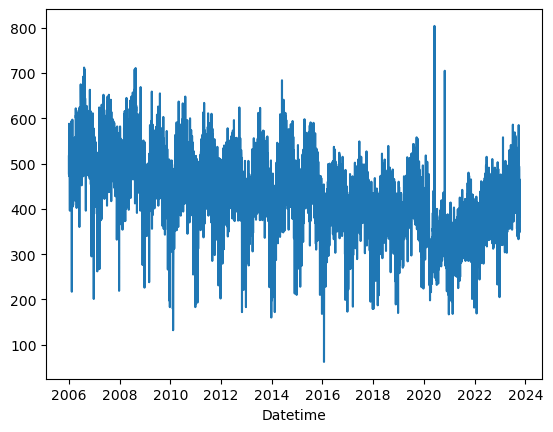

In [49]:
crime_count_per_day = timeseries.groupby(timeseries['Datetime'].dt.date).size()

crime_count_per_day.plot()

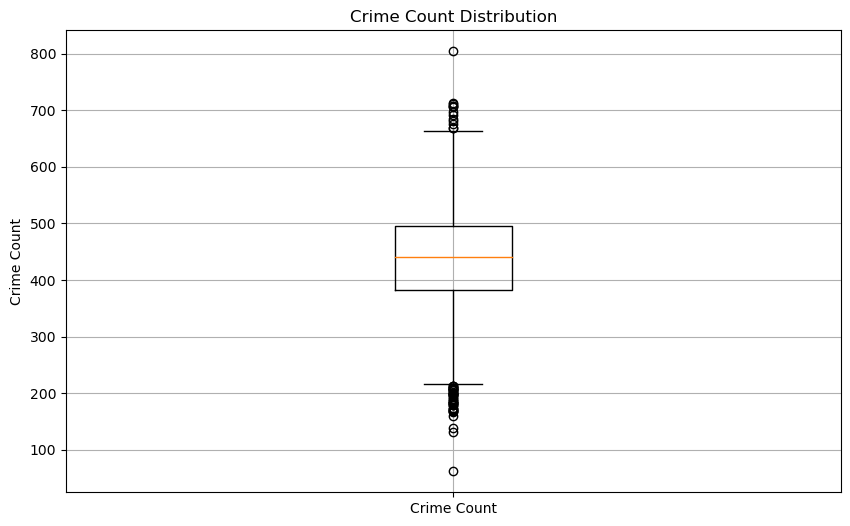

In [53]:
crime_counts = crime_count_per_day

plt.figure(figsize=(10, 6))
plt.boxplot(crime_counts)

plt.title('Crime Count Distribution')
plt.ylabel('Crime Count')
plt.xticks([1], ['Crime Count'])  # Adjust the x-ticks if necessary

plt.grid(True)
plt.show()

In [54]:
crime_count_per_day.describe()

count    6494.000000
mean      438.111334
std        82.988136
min        62.000000
25%       383.000000
50%       441.000000
75%       495.000000
max       804.000000
dtype: float64

In [39]:
print('Least Crime Count & Date')
print(crime_count_per_day[crime_count_per_day==crime_count_per_day.min()])

Least Crime Count & Date
Datetime
2016-01-23    62
dtype: int64


In [40]:
print('Most Crime Count & Date')
print(crime_count_per_day[crime_count_per_day==crime_count_per_day.max()])

Most Crime Count & Date
Datetime
2020-06-01    804
dtype: int64


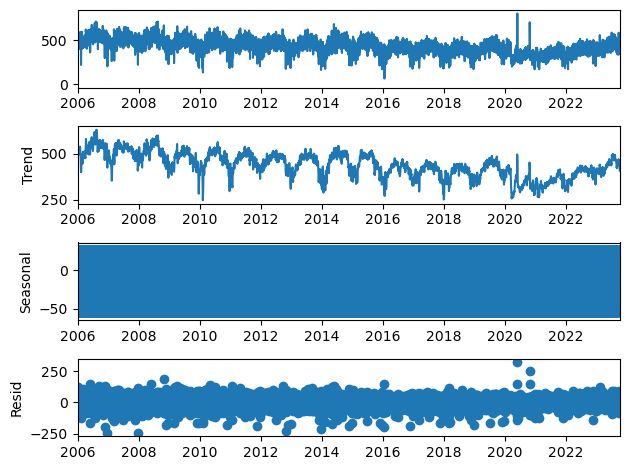

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose

crime_count_per_day.index = pd.to_datetime(crime_count_per_day.index)  # Ensure DateTimeIndex
crime_count_per_day = crime_count_per_day.asfreq('D', fill_value=0)

result = seasonal_decompose(crime_count_per_day, model='add')  # model='mul' also works
result.plot();

In [56]:
train_data = crime_count_per_day.iloc[:len(crime_count_per_day)-1-7]
test_data = crime_count_per_day.iloc[len(crime_count_per_day)-1-7:]

In [57]:
from pmdarima import auto_arima
auto_arima(train_data).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6487
Model:               SARIMAX(5, 1, 4)   Log Likelihood              -34473.302
Date:                Wed, 13 Mar 2024   AIC                          68968.605
Time:                        20:09:21   BIC                          69043.156
Sample:                    01-01-2006   HQIC                         68994.393
                         - 10-05-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -9.116e-05      0.183     -0.000      1.000      -0.358       0.358
ar.L1          0.1329      0.043      3.121      0.002       0.049       0.216
ar.L2         -0.8820      0.013    -68.814      0.000      -0.907      -0.857
ar.L3          0.2321      0.045      5.181      0.000       0.144       0.320
ar.L4         -0.2660      0.019    -14.057      0.000      -0.303      -0.229
ar.L5         -0.2704      0.016    -16.821      0.000      -0.302      -0.239
ma.L1         -0.6952      0.043    -16.239      0.000      -0.779      -0.611
ma.L2          0.7270      0.024     30.334      0.000       0.680       0.774
ma.L3         -0.9808      0.027    -36.338      0.000      -1.034      -0.928
ma.L4          0.2222      0.040      5.624      0.000       0.145       0.300
sigma2      2544.6121     28.763     88.468      0.000    2488.238    2600.986
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              4115.59
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA 

model = ARIMA(train_data,order=(5,1,4))
results = model.fit()
results.summary()

C:\Users\aryan\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6487
Model:                 ARIMA(5, 1, 4)   Log Likelihood              -34481.074
Date:                Wed, 13 Mar 2024   AIC                          68982.149
Time:                        20:09:43   BIC                          69049.923
Sample:                    01-01-2006   HQIC                         69005.592
                         - 10-05-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2567      0.047      5.461      0.000       0.165       0.349
ar.L2         -0.8846      0.013    -67.657      0.000      -0.910      -0.859
ar.L3          0.3805      0.049      7.796      0.000       0.285       0.476
ar.L4         -0.2988      0.021    -13.913      0.000      -0.341      -0.257
ar.L5         -0.2201      0.017    -12.826      0.000      -0.254      -0.186
ma.L1         -0.7860      0.047    -16.737      0.000      -0.878      -0.694
ma.L2          0.7802      0.026     30.505      0.000       0.730       0.830
ma.L3         -1.0412      0.029    -35.441      0.000      -1.099      -0.984
ma.L4          0.3049      0.043      7.102      0.000       0.221       0.389
sigma2      2545.8398     28.353     89.791      0.000    2490.269    2601.410
===================================================================================
Ljung-Box (L1) (Q):                   3.79   Jarque-Bera (JB):              4100.58
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions = results.predict(start=start, end=end).rename('ARIMA(5,1,4) Predictions')
mean_absolute_percentage_error(test_data,predictions)

9.54398046031732

In [60]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_data,predictions)

36.73475344585286

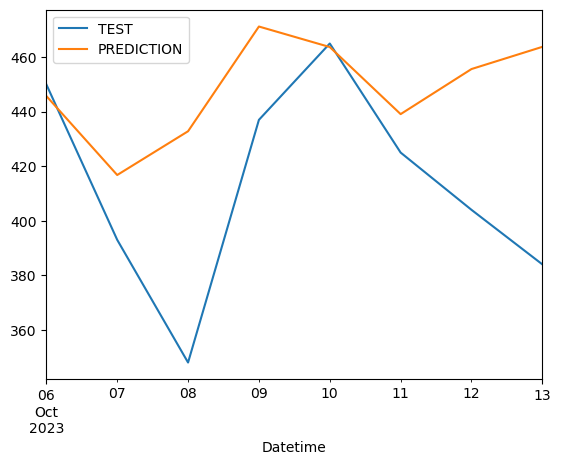

In [61]:
test_data.plot(legend=True,label='TEST')
predictions.plot(legend=True,label='PREDICTION');

In [62]:
from prophet import Prophet
crime_count_per_day_fb=pd.DataFrame()


crime_count_per_day_fb['y']=crime_count_per_day.values
crime_count_per_day_fb['ds']=crime_count_per_day.index

In [63]:
crime_count_per_day_fb

,y,ds
0,516,2006-01-01
1,476,2006-01-02
2,0,2006-01-03
3,588,2006-01-04
4,477,2006-01-05
...,...,...
6490,437,2023-10-09
6491,465,2023-10-10
6492,425,2023-10-11
6493,404,2023-10-12


In [64]:
train_data_fb = crime_count_per_day_fb.iloc[:len(crime_count_per_day_fb)-1-7]
test_data_fb = crime_count_per_day_fb.iloc[len(crime_count_per_day_fb)-1-7:]

In [65]:
m = Prophet()
m.fit(train_data_fb)

future = m.make_future_dataframe(periods=8,freq = 'D')
forecast = m.predict(future)
forecast.tail()

20:09:57 - cmdstanpy - INFO - Chain [1] start processing
20:10:00 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
6490,2023-10-09,420.341015,370.804819,503.092350,420.341015,420.341015,17.157838,17.157838,17.157838,4.079991,4.079991,4.079991,13.077847,13.077847,13.077847,0.0,0.0,0.0,437.498853
6491,2023-10-10,420.403380,398.110027,528.057256,420.403380,420.403380,43.544188,43.544188,43.544188,30.737765,30.737765,30.737765,12.806423,12.806423,12.806423,0.0,0.0,0.0,463.947568
6492,2023-10-11,420.465745,396.617332,529.783244,420.465745,420.465745,41.974002,41.974002,41.974002,29.308461,29.308461,29.308461,12.665541,12.665541,12.665541,0.0,0.0,0.0,462.439747
6493,2023-10-12,420.528110,383.617884,512.628203,420.528110,420.528110,27.168566,27.168566,27.168566,14.511895,14.511895,14.511895,12.656671,12.656671,12.656671,0.0,0.0,0.0,447.696676
6494,2023-10-13,420.590475,371.210823,509.787956,420.590475,420.590475,19.999045,19.999045,19.999045,7.222544,7.222544,7.222544,12.776501,12.776501,12.776501,0.0,0.0,0.0,440.589520


<AxesSubplot:xlabel='ds'>

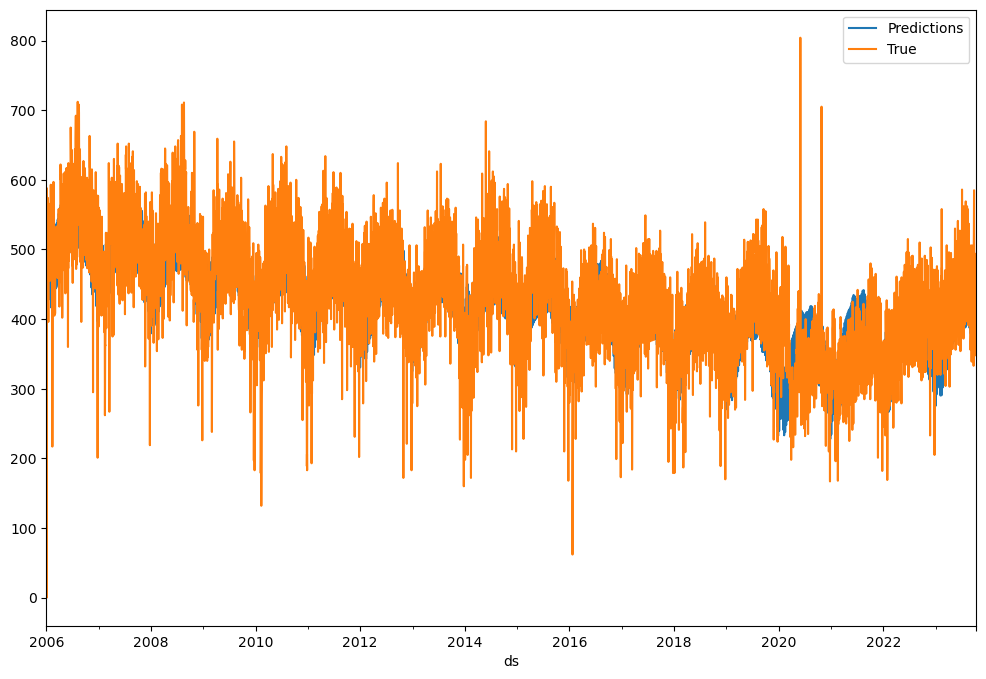

In [66]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))

crime_count_per_day_fb.plot(x='ds',y='y',label='True',legend=True,ax=ax)

In [67]:
pred=forecast[-8:]['yhat']
mean_absolute_percentage_error(test_data_fb['y'],pred)

5.973176245736132

In [68]:
mean_absolute_error(test_data_fb['y'],pred)

23.549812511333975

In [50]:
mean_temp_per_day = timeseries.groupby(timeseries['Datetime'].dt.date)['temperature_2m_mean (°F)'].mean()

crime_count_per_day = timeseries.groupby(timeseries['Datetime'].dt.date).size()

# Now, let's create a DataFrame for count_temp_per_day that includes both the mean temperature and crime count
count_temp_per_day = mean_temp_per_day.to_frame(name='Mean Temperature (°F)')
count_temp_per_day['Crime Count'] = crime_count_per_day

count_temp_per_day

,Mean Temperature (°F),Crime Count
Datetime,,
2006-01-01,36.5,516
2006-01-02,38.0,476
2006-01-04,36.3,588
2006-01-05,42.5,477
2006-01-06,37.0,489
...,...,...
2023-10-09,53.8,437
2023-10-10,55.7,465
2023-10-11,59.1,425


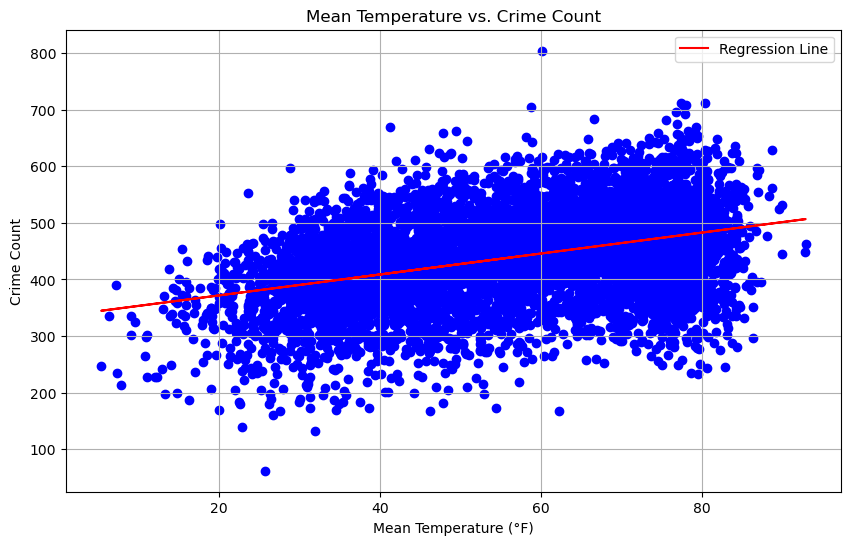

In [43]:
# Assuming count_temp_per_day is your DataFrame with 'Mean Temperature (°F)' and 'Crime Count' columns
x = count_temp_per_day['Mean Temperature (°F)']
y = count_temp_per_day['Crime Count']

# Calculate the line of best fit
slope, intercept = np.polyfit(x, y, 1)
line = slope * x + intercept

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue')

# Add the regression line
plt.plot(x, line, color='red', label='Regression Line')

# Add titles and labels
plt.title('Mean Temperature vs. Crime Count')
plt.xlabel('Mean Temperature (°F)')
plt.ylabel('Crime Count')
plt.grid(True)

# Show the plot with the regression line
plt.legend()
plt.show()

In [51]:
count_temp_per_day.corr()

,Mean Temperature (°F),Crime Count
Mean Temperature (°F),1.000000,0.384421
Crime Count,0.384421,1.000000


<AxesSubplot:>

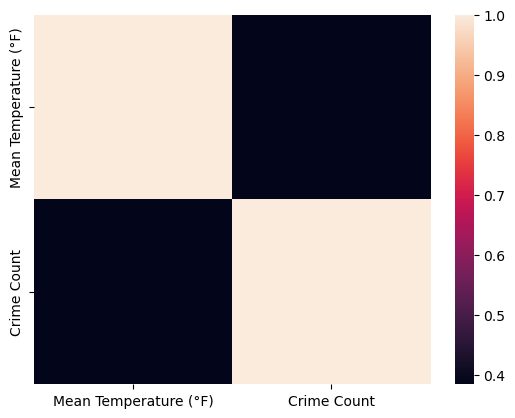

In [44]:
sns.heatmap(count_temp_per_day.corr())

In [52]:
mean_rain_per_day = timeseries.groupby(timeseries['Datetime'].dt.date)['precipitation_sum (mm)'].mean()
crime_count_per_day = timeseries.groupby(timeseries['Datetime'].dt.date).size()

# Now, let's create a DataFrame for count_temp_per_day that includes both the mean temperature and crime count
count_rain_per_day = mean_rain_per_day.to_frame(name='precipitation_sum (mm)')
count_rain_per_day['Crime Count'] = crime_count_per_day

count_rain_per_day

,precipitation_sum (mm),Crime Count
Datetime,,
2006-01-01,0.0,516
2006-01-02,12.6,476
2006-01-04,0.3,588
2006-01-05,0.0,477
2006-01-06,0.0,489
...,...,...
2023-10-09,0.2,437
2023-10-10,0.1,465
2023-10-11,0.0,425


In [47]:
count_rain_per_day[count_rain_per_day['precipitation_sum (mm)']>0]

,precipitation_sum (mm),Crime Count
Datetime,,
2006-01-02,12.6,476
2006-01-04,0.3,588
2006-01-11,9.4,539
2006-01-14,13.4,460
2006-01-15,7.8,396
...,...,...
2023-09-30,0.4,350
2023-10-06,1.8,450
2023-10-07,5.6,393


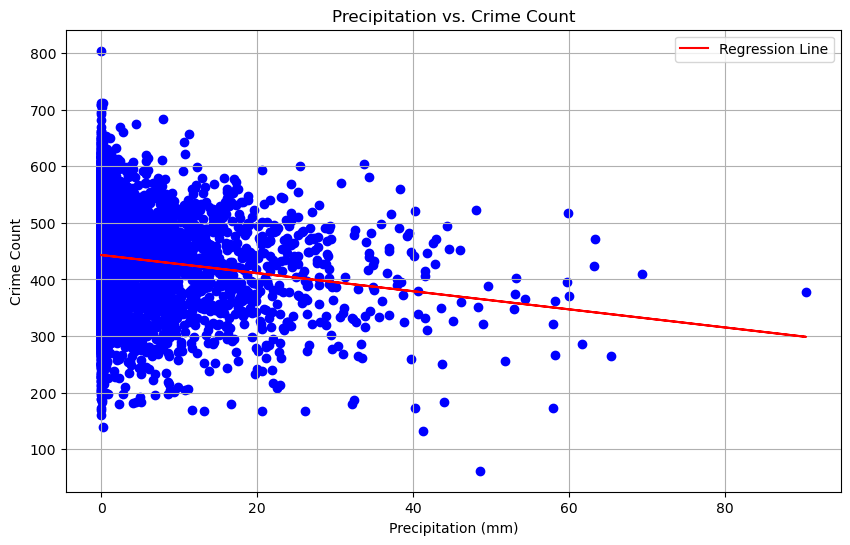

In [53]:
# Assuming count_temp_per_day is your DataFrame with 'Mean Temperature (°F)' and 'Crime Count' columns
x = count_rain_per_day['precipitation_sum (mm)']
y = count_rain_per_day['Crime Count']

# Calculate the line of best fit
slope, intercept = np.polyfit(x, y, 1)
line = slope * x + intercept

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue')

# Add the regression line
plt.plot(x, line, color='red', label='Regression Line')

# Add titles and labels
plt.title('Precipitation vs. Crime Count')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Crime Count')
plt.grid(True)

# Show the plot with the regression line
plt.legend()
plt.show()

In [54]:
count_rain_per_day.corr()

,precipitation_sum (mm),Crime Count
precipitation_sum (mm),1.000000,-0.138874
Crime Count,-0.138874,1.000000


<AxesSubplot:>

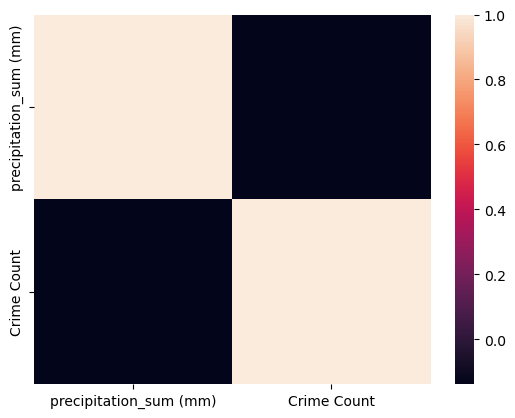

In [50]:
sns.heatmap(count_rain_per_day.corr())

# Time Series - Monthly

<AxesSubplot:xlabel='Year_Month'>

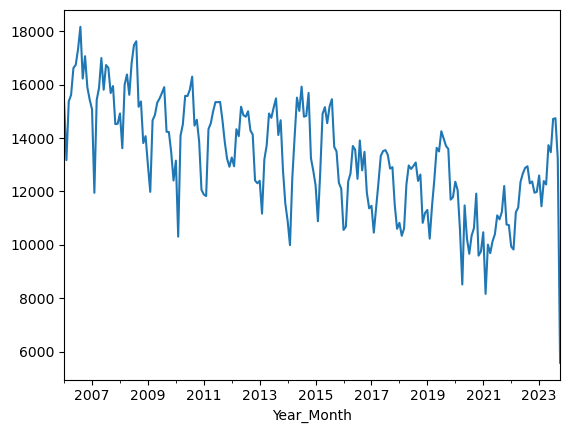

In [85]:
timeseries['Year_Month'] = timeseries['Datetime'].dt.to_period('M')

# Group data by year and month, and count the number of crimes per month within each year
crime_count_per_year_month = timeseries.groupby('Year_Month').size()
crime_count_per_year_month.index = pd.to_datetime(crime_count_per_year_month.index.to_timestamp())
crime_count_per_year_month.plot()

In [88]:
print('Least Crime Count & Month')
print('2021-02-01',crime_count_per_year_month.loc['2021-02-01'])

Least Crime Count & Month
2021-02-01 8161


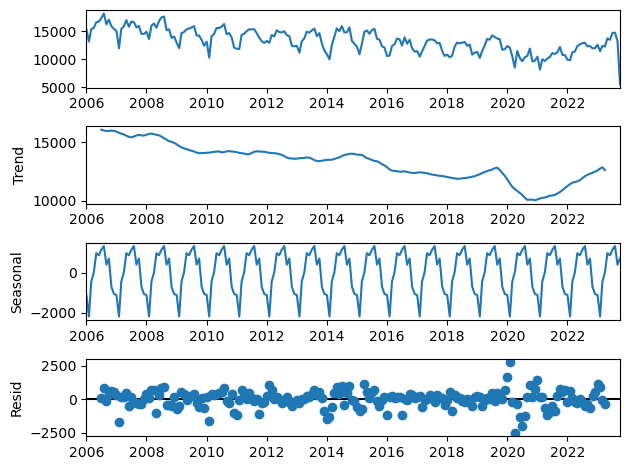

In [84]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Convert PeriodIndex back to DatetimeIndex
crime_count_per_year_month.index = pd.to_datetime(crime_count_per_year_month.index.to_timestamp())

result = seasonal_decompose(crime_count_per_year_month, model='add')  # model='mul' also works
result.plot();

<AxesSubplot:xlabel='Year_Month'>

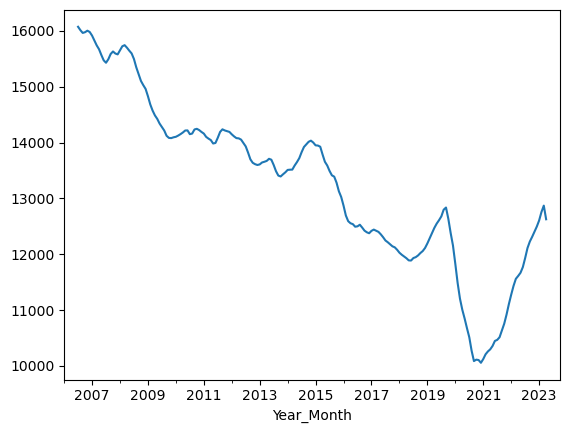

In [71]:
result.trend.plot()

In [72]:
len(crime_count_per_year_month)

214

In [73]:
train_data = crime_count_per_year_month.iloc[:len(crime_count_per_year_month)-1-7]
test_data = crime_count_per_year_month.iloc[len(crime_count_per_year_month)-1-7:]

In [74]:
from pmdarima import auto_arima
auto_arima(train_data).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  206
Model:               SARIMAX(4, 1, 3)   Log Likelihood               -1685.283
Date:                Wed, 13 Mar 2024   AIC                           3386.566
Time:                        20:12:35   BIC                           3413.150
Sample:                    01-01-2006   HQIC                          3397.319
                         - 02-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5232      0.149      3.519      0.000       0.232       0.815
ar.L2          0.6765      0.207      3.266      0.001       0.271       1.082
ar.L3         -0.4585      0.093     -4.946      0.000      -0.640      -0.277
ar.L4         -0.4286      0.070     -6.118      0.000      -0.566      -0.291
ma.L1         -0.9610      0.151     -6.356      0.000      -1.257      -0.665
ma.L2         -0.3619      0.254     -1.425      0.154      -0.860       0.136
ma.L3          0.7452      0.151      4.921      0.000       0.448       1.042
sigma2      9.006e+05   3.91e-07    2.3e+12      0.000    9.01e+05    9.01e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                33.78
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.51
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.39e+28. Standard errors may be unstable.
"""

In [75]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA 

model = ARIMA(train_data,order=(4,1,3))
results = model.fit()
results.summary()

C:\Users\aryan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aryan\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  206
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -1685.283
Date:                Wed, 13 Mar 2024   AIC                           3386.566
Time:                        20:12:36   BIC                           3413.150
Sample:                    01-01-2006   HQIC                          3397.319
                         - 02-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5232      0.149      3.519      0.000       0.232       0.815
ar.L2          0.6765      0.207      3.266      0.001       0.271       1.082
ar.L3         -0.4585      0.093     -4.946      0.000      -0.640      -0.277
ar.L4         -0.4286      0.070     -6.118      0.000      -0.566      -0.291
ma.L1         -0.9610      0.151     -6.356      0.000      -1.257      -0.665
ma.L2         -0.3619      0.254     -1.425      0.154      -0.860       0.136
ma.L3          0.7452      0.151      4.921      0.000       0.448       1.042
sigma2      9.006e+05   3.91e-07    2.3e+12      0.000    9.01e+05    9.01e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                33.78
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.51
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.39e+28. Standard errors may be unstable.
"""

In [76]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions = results.predict(start=start, end=end).rename('ARIMA(5,1,4) Predictions')
mean_absolute_percentage_error(test_data,predictions)

23.463334262163258

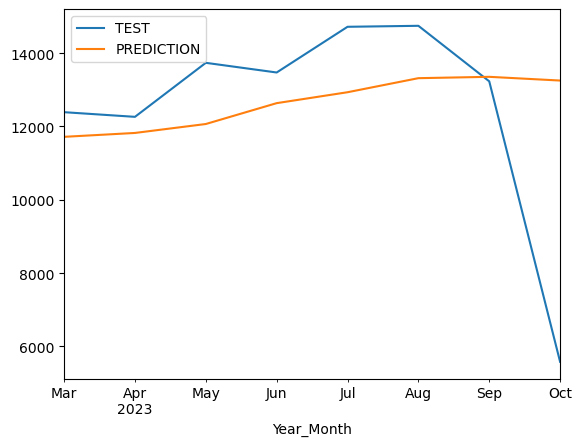

In [77]:
test_data.plot(legend=True,label='TEST')
predictions.plot(legend=True,label='PREDICTION');

# Cuting off dataset at March 2020

In [113]:
crime_count_per_year_month_till_mar_2020=crime_count_per_year_month.loc[:'2020-02-01']

<AxesSubplot:xlabel='Year_Month'>

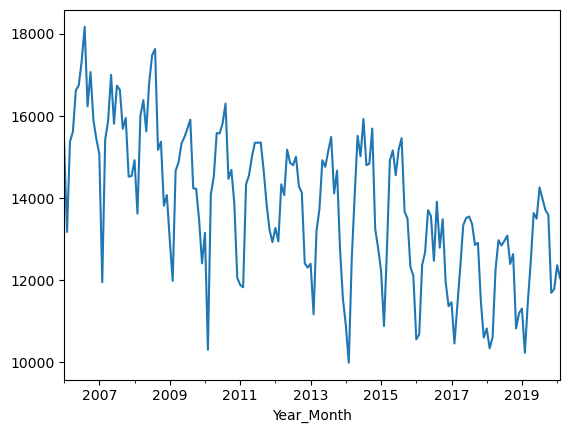

In [115]:
crime_count_per_year_month_till_mar_2020.plot()

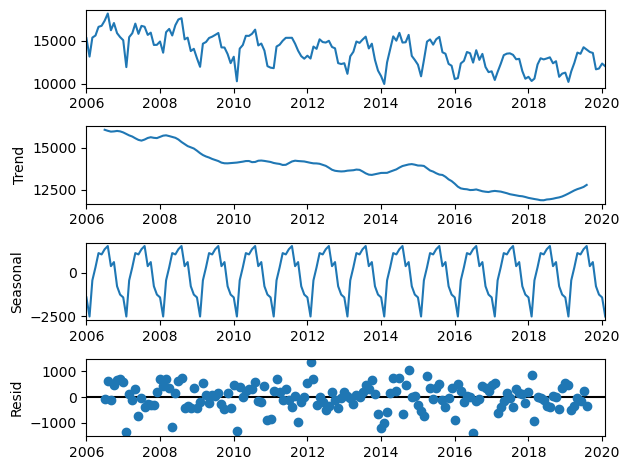

In [117]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Convert PeriodIndex back to DatetimeIndex
#crime_count_per_year_month.index = pd.to_datetime(crime_count_per_year_month_till_mar_2020.index.to_timestamp())

result = seasonal_decompose(crime_count_per_year_month_till_mar_2020, model='add')  # model='mul' also works
result.plot();

<AxesSubplot:xlabel='Year_Month'>

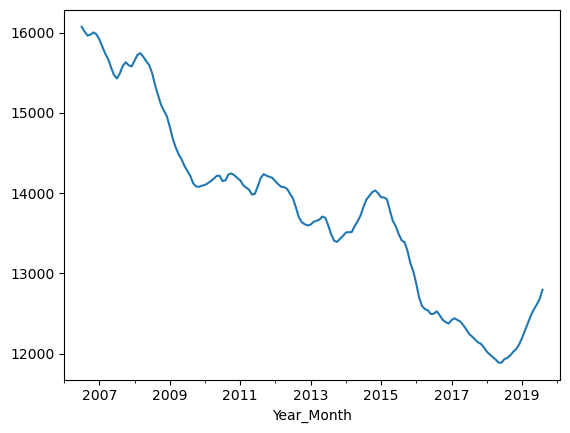

In [118]:
result.trend.plot()

In [124]:
train_data = crime_count_per_year_month_till_mar_2020.iloc[:len(crime_count_per_year_month_till_mar_2020)-1-7]
test_data = crime_count_per_year_month_till_mar_2020.iloc[len(crime_count_per_year_month_till_mar_2020)-1-7:]

In [125]:
from pmdarima import auto_arima
auto_arima(train_data).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  162
Model:               SARIMAX(1, 1, 4)   Log Likelihood               -1346.392
Date:                Wed, 13 Mar 2024   AIC                           2704.784
Time:                        20:22:47   BIC                           2723.272
Sample:                    01-01-2006   HQIC                          2712.291
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6065      0.112      5.420      0.000       0.387       0.826
ma.L1         -0.8994      0.129     -6.964      0.000      -1.153      -0.646
ma.L2          0.2596      0.100      2.606      0.009       0.064       0.455
ma.L3         -0.1494      0.100     -1.492      0.136      -0.346       0.047
ma.L4         -0.1572      0.088     -1.790      0.073      -0.329       0.015
sigma2      1.037e+06    1.2e+05      8.638      0.000    8.02e+05    1.27e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.48   Prob(JB):                         0.95
Heteroskedasticity (H):               0.51   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [126]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA 

model = ARIMA(train_data,order=(1,1,4))
results = model.fit()
results.summary()

C:\Users\aryan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  162
Model:                 ARIMA(1, 1, 4)   Log Likelihood               -1346.392
Date:                Wed, 13 Mar 2024   AIC                           2704.784
Time:                        20:22:53   BIC                           2723.272
Sample:                    01-01-2006   HQIC                          2712.291
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6065      0.112      5.420      0.000       0.387       0.826
ma.L1         -0.8994      0.129     -6.964      0.000      -1.153      -0.646
ma.L2          0.2596      0.100      2.606      0.009       0.064       0.455
ma.L3         -0.1494      0.100     -1.492      0.136      -0.346       0.047
ma.L4         -0.1572      0.088     -1.790      0.073      -0.329       0.015
sigma2      1.037e+06    1.2e+05      8.638      0.000    8.02e+05    1.27e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.48   Prob(JB):                         0.95
Heteroskedasticity (H):               0.51   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [127]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions = results.predict(start=start, end=end).rename('ARIMA(1,1,4) Predictions')
mean_absolute_percentage_error(test_data,predictions)

5.472133494509905

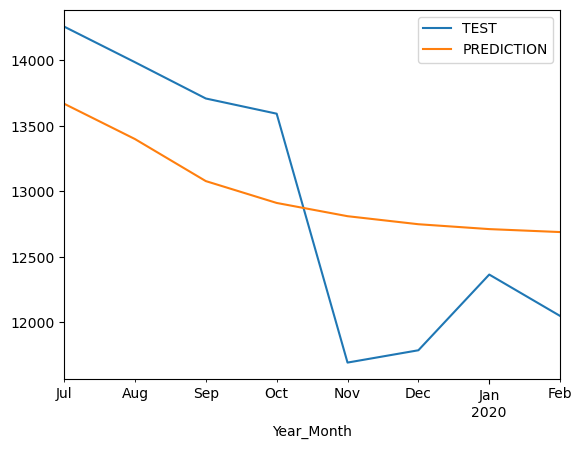

In [128]:
test_data.plot(legend=True,label='TEST')
predictions.plot(legend=True,label='PREDICTION');

# Predicting Crime Type

In [129]:
data=pd.read_csv('data/data_full_features.csv')
data=data.drop('Unnamed: 0',axis=1)
data

,crime_type,point_x,point_y,Year,Month,Day,Hour,Minute,Weekday,IsWeekend,street_name,block_number,distance_to_nearest_police_station,temperature_2m_max (°F),temperature_2m_min (°F),temperature_2m_mean (°F),precipitation_sum (mm),precipitation_hours (h),Unemployment Rate of a Population
0,Robbery Firearm,-75.072610,40.041574,2023,10,13,23,54,4,0,BLOCK LARGE,6600,0.017699,65.5,51.5,57.2,0.0,0.0,5.4
1,Other Assaults,-75.172952,39.999995,2023,10,13,23,27,4,0,BLOCK N,2900,0.019584,65.5,51.5,57.2,0.0,0.0,5.4
2,Thefts,-75.108462,39.994303,2023,10,13,23,27,4,0,BLOCK JOYCE,3200,0.028199,65.5,51.5,57.2,0.0,0.0,5.4
3,Thefts,-75.136074,39.991890,2023,10,13,23,24,4,0,BLOCK N,2700,0.029554,65.5,51.5,57.2,0.0,0.0,5.4
4,Robbery Firearm,-75.107092,40.032184,2023,10,13,23,19,4,0,BLOCK ADAMS,700,0.038528,65.5,51.5,57.2,0.0,0.0,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845090,Weapon Violations,-75.162731,39.996640,2006,1,1,0,10,6,1,BLOCK W,1900,0.016373,45.5,30.5,36.5,0.0,0.0,6.7
2845091,Weapon Violations,-75.147908,40.054432,2006,1,1,0,9,6,1,BLOCK N,6600,0.014318,45.5,30.5,36.5,0.0,0.0,6.7
2845092,Weapon Violations,-75.230637,39.937516,2006,1,1,0,5,6,1,BLOCK S,1700,0.015256,45.5,30.5,36.5,0.0,0.0,6.7
2845093,Weapon Violations,-75.232361,39.953284,2006,1,1,0,4,6,1,BLOCK S,400,0.001530,45.5,30.5,36.5,0.0,0.0,6.7


In [130]:
feature_data_pipeline = ColumnTransformer([
    ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ["street_name"]),
    ('passthrough', 'passthrough', ['IsWeekend']), 
    ("numerical", StandardScaler(), [
        "block_number", "distance_to_nearest_police_station",
        "temperature_2m_max (°F)", "temperature_2m_min (°F)",
        "temperature_2m_mean (°F)", "precipitation_sum (mm)", 
        "precipitation_hours (h)", "Unemployment Rate of a Population"])
])

In [131]:
#Crime Classification:
X_train, X_test, y_train, y_test = train_test_split(data.drop("crime_type", axis=1), data["crime_type"].values.reshape(-1, 1), test_size=0.2)
crimetype_encoder = LabelEncoder()
y_train_encoded = crimetype_encoder.fit_transform(y_train)
y_test_encoded = crimetype_encoder.transform(y_test)

X_train_encoded = feature_data_pipeline.fit_transform(X_train)
X_test_encoded = feature_data_pipeline.transform(X_test)

C:\Users\aryan\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aryan\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [132]:
classifiers = [KNeighborsClassifier()] #, DecisionTreeClassifier(), RandomForestClassifier(), MLPClassifier(), LogisticRegression(), SVC(), XGBClassifier()

classification_results = []

model=KNeighborsClassifier()
print(model)
model.fit(X_train_encoded, y_train_encoded)
    #dump(model, f'models/classification/{str(model)}_crime_type.joblib')
y_pred = model.predict(X_test_encoded)
accuracy = accuracy_score(y_test_encoded, y_pred)
precision, recall, fscore, support = precision_recall_fscore_support(y_test_encoded, y_pred)
f1score = f1_score(y_test_encoded, y_pred, average='weighted')
    
    
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1score)
    
classification_results.append([str(model), accuracy, precision, recall, f1score])


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

KNeighborsClassifier()


C:\Users\aryan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
  0%|                                                                                            | 0/1 [03:41<?, ?it/s]

Accuracy: 0.2147713872471745
Precision: [0.0710532  0.05780541 0.28434542 0.01794688 0.12395915 0.08398577
 0.11858006 0.15286299 0.04615385 0.0152381  0.11619988 0.1953125
 0.03311258 0.34637514 0.09255158 0.20004585 0.23448276 0.19659886
 0.14405594 0.33704453 0.08484848 0.04098361 0.15714286 0.04123113
 0.03266219 0.18690638 0.35008423 0.18531469 0.14737461 0.06370495]
Recall: [0.1530907  0.11146514 0.52413063 0.01481921 0.11349252 0.08307794
 0.07939719 0.1227422  0.02109375 0.00672834 0.09084655 0.13736264
 0.00813008 0.26923077 0.04770201 0.16105814 0.0923913  0.18648944
 0.02612224 0.31534091 0.01741294 0.00442347 0.01689708 0.00745016
 0.00618225 0.12594286 0.32144625 0.09322779 0.08916971 0.01112249]
F1 Score: 0.19617016989279126


In [133]:
model=RandomForestClassifier()
print(model)
model.fit(X_train_encoded, y_train_encoded)
    #dump(model, f'models/classification/{str(model)}_crime_type.joblib')
y_pred = model.predict(X_test_encoded)
accuracy = accuracy_score(y_test_encoded, y_pred)
precision, recall, fscore, support = precision_recall_fscore_support(y_test_encoded, y_pred)
f1score = f1_score(y_test_encoded, y_pred, average='weighted')
    
    
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1score)    
#classification_results.append([str(model), accuracy, precision, recall, f1score])


RandomForestClassifier()


KeyboardInterrupt: 

Had to interupt since it was taking too long to train 

# Predicting Crime Severity

In [2]:
data=pd.read_csv('data/data_full_features.csv')
data=data.drop('Unnamed: 0',axis=1)
data

,crime_type,point_x,point_y,Year,Month,Day,Hour,Minute,Weekday,IsWeekend,street_name,block_number,distance_to_nearest_police_station,temperature_2m_max (°F),temperature_2m_min (°F),temperature_2m_mean (°F),precipitation_sum (mm),precipitation_hours (h),Unemployment Rate of a Population
0,Robbery Firearm,-75.072610,40.041574,2023,10,13,23,54,4,0,BLOCK LARGE,6600,0.017699,65.5,51.5,57.2,0.0,0.0,5.4
1,Other Assaults,-75.172952,39.999995,2023,10,13,23,27,4,0,BLOCK N,2900,0.019584,65.5,51.5,57.2,0.0,0.0,5.4
2,Thefts,-75.108462,39.994303,2023,10,13,23,27,4,0,BLOCK JOYCE,3200,0.028199,65.5,51.5,57.2,0.0,0.0,5.4
3,Thefts,-75.136074,39.991890,2023,10,13,23,24,4,0,BLOCK N,2700,0.029554,65.5,51.5,57.2,0.0,0.0,5.4
4,Robbery Firearm,-75.107092,40.032184,2023,10,13,23,19,4,0,BLOCK ADAMS,700,0.038528,65.5,51.5,57.2,0.0,0.0,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845090,Weapon Violations,-75.162731,39.996640,2006,1,1,0,10,6,1,BLOCK W,1900,0.016373,45.5,30.5,36.5,0.0,0.0,6.7
2845091,Weapon Violations,-75.147908,40.054432,2006,1,1,0,9,6,1,BLOCK N,6600,0.014318,45.5,30.5,36.5,0.0,0.0,6.7
2845092,Weapon Violations,-75.230637,39.937516,2006,1,1,0,5,6,1,BLOCK S,1700,0.015256,45.5,30.5,36.5,0.0,0.0,6.7
2845093,Weapon Violations,-75.232361,39.953284,2006,1,1,0,4,6,1,BLOCK S,400,0.001530,45.5,30.5,36.5,0.0,0.0,6.7


In [3]:
crime_severity_mapping = {
    'Robbery Firearm': 'Severe',
    'Other Assaults': 'Moderate',
    'Thefts': 'Minor',
    'Vandalism/Criminal Mischief': 'Moderate',
    'Burglary Non-Residential': 'Moderate',
    'Motor Vehicle Theft': 'Moderate',
    'Aggravated Assault No Firearm': 'Severe',
    'Robbery No Firearm': 'Moderate',
    'Weapon Violations': 'Moderate',
    'Fraud': 'Minor',
    'Burglary Residential': 'Moderate',
    'Liquor Law Violations': 'Minor',
    'Receiving Stolen Property': 'Minor',
    'All Other Offenses': 'Minor',
    'Aggravated Assault Firearm': 'Severe',
    'Theft from Vehicle': 'Minor',
    'Rape': 'Severe',
    'Other Sex Offenses (Not Commercialized)': 'Moderate',
    'Narcotic / Drug Law Violations': 'Moderate',
    'Disorderly Conduct': 'Minor',
    'DRIVING UNDER THE INFLUENCE': 'Moderate',
    'Arson': 'Severe',
    'Embezzlement': 'Minor',
    'Forgery and Counterfeiting': 'Minor',
    'Homicides': 'Severe',
    'Offenses Against Family and Children': 'Moderate',
    'Prostitution and Commercialized Vice': 'Moderate',
    'Public Drunkenness': 'Minor',
    'Vagrancy/Loitering': 'Minor',
    'Gambling Violations': 'Minor'
}

data['degree_of_crime'] = data['crime_type'].map(crime_severity_mapping)

# Handle any crimes that were not classified (if any)
#data['degree_of_crime'].fillna('Unknown', inplace=True)
data['degree_of_crime'].value_counts()

Minor       1370498
Moderate    1261897
Severe       212700
Name: degree_of_crime, dtype: int64

In [4]:
feature_data_pipeline = ColumnTransformer([
    ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ["street_name"]),
    ('passthrough', 'passthrough', ['IsWeekend']), 
    ("numerical", StandardScaler(), [
        "block_number", "distance_to_nearest_police_station",
        "temperature_2m_max (°F)", "temperature_2m_min (°F)",
        "temperature_2m_mean (°F)", "precipitation_sum (mm)", 
        "precipitation_hours (h)", "Unemployment Rate of a Population"])
])

In [5]:
#Crime Classification:
X_train, X_test, y_train, y_test = train_test_split(data.drop(["crime_type","degree_of_crime"], axis=1), data["degree_of_crime"].values.reshape(-1, 1), test_size=0.2)
crimetype_encoder = LabelEncoder()
y_train_encoded = crimetype_encoder.fit_transform(y_train)
y_test_encoded = crimetype_encoder.transform(y_test)

X_train_encoded = feature_data_pipeline.fit_transform(X_train)
X_test_encoded = feature_data_pipeline.transform(X_test)

C:\Users\aryan\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aryan\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
classifiers = [KNeighborsClassifier()] #, DecisionTreeClassifier(), RandomForestClassifier(), MLPClassifier(), LogisticRegression(), SVC(), XGBClassifier()

classification_results = []

model=KNeighborsClassifier()
print(model)
model.fit(X_train_encoded, y_train_encoded)
    #dump(model, f'models/classification/{str(model)}_crime_type.joblib')
y_pred = model.predict(X_test_encoded)
accuracy = accuracy_score(y_test_encoded, y_pred)
precision, recall, fscore, support = precision_recall_fscore_support(y_test_encoded, y_pred)
f1score = f1_score(y_test_encoded, y_pred, average='weighted')
    
    
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1score)
    
classification_results.append([str(model), accuracy, precision, recall, f1score])


KNeighborsClassifier()


C:\Users\aryan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy: 0.5264692391642458
Precision: [0.54178608 0.51219977 0.20578778]
Recall: [0.63818714 0.48980989 0.0226554 ]
F1 Score: 0.5075752092567728


# Predicting Crime Location (Latitude & Longitude)

In [3]:
data

,crime_type,point_x,point_y,Year,Month,Day,Hour,Minute,Weekday,IsWeekend,street_name,block_number,distance_to_nearest_police_station,temperature_2m_max (°F),temperature_2m_min (°F),temperature_2m_mean (°F),precipitation_sum (mm),precipitation_hours (h),Unemployment Rate of a Population
0,Robbery Firearm,-75.072610,40.041574,2023,10,13,23,54,4,0,BLOCK LARGE,6600,0.017699,65.5,51.5,57.2,0.0,0.0,5.4
1,Other Assaults,-75.172952,39.999995,2023,10,13,23,27,4,0,BLOCK N,2900,0.019584,65.5,51.5,57.2,0.0,0.0,5.4
2,Thefts,-75.108462,39.994303,2023,10,13,23,27,4,0,BLOCK JOYCE,3200,0.028199,65.5,51.5,57.2,0.0,0.0,5.4
3,Thefts,-75.136074,39.991890,2023,10,13,23,24,4,0,BLOCK N,2700,0.029554,65.5,51.5,57.2,0.0,0.0,5.4
4,Robbery Firearm,-75.107092,40.032184,2023,10,13,23,19,4,0,BLOCK ADAMS,700,0.038528,65.5,51.5,57.2,0.0,0.0,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845090,Weapon Violations,-75.162731,39.996640,2006,1,1,0,10,6,1,BLOCK W,1900,0.016373,45.5,30.5,36.5,0.0,0.0,6.7
2845091,Weapon Violations,-75.147908,40.054432,2006,1,1,0,9,6,1,BLOCK N,6600,0.014318,45.5,30.5,36.5,0.0,0.0,6.7
2845092,Weapon Violations,-75.230637,39.937516,2006,1,1,0,5,6,1,BLOCK S,1700,0.015256,45.5,30.5,36.5,0.0,0.0,6.7
2845093,Weapon Violations,-75.232361,39.953284,2006,1,1,0,4,6,1,BLOCK S,400,0.001530,45.5,30.5,36.5,0.0,0.0,6.7


In [11]:
feature_data_pipeline = ColumnTransformer([
    ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ["street_name","crime_type"]),
    ('passthrough', 'passthrough', ['IsWeekend']), 
    ("numerical", StandardScaler(), [
        "block_number", "distance_to_nearest_police_station",
        "temperature_2m_max (°F)", "temperature_2m_min (°F)",
        "temperature_2m_mean (°F)", "precipitation_sum (mm)", 
        "precipitation_hours (h)", "Unemployment Rate of a Population"])
])

In [12]:
X = data.drop(columns=['point_x', 'point_y']) # Features
y = data[['point_x', 'point_y']] # Targets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_encoded = feature_data_pipeline.fit_transform(X_train)
X_test_encoded = feature_data_pipeline.transform(X_test)

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Create a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train_encoded, y_train)

KeyboardInterrupt: 

Had to interupt since it was taking too long to train